In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
while "notebooks" in os.getcwd():
    os.chdir("..")

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import torch
from openai import OpenAI
import json
import pandas as pd
import numpy as np
from src.utils import get_context_length
from transformers import AutoTokenizer
from tqdm import tqdm
from datasets import load_dataset
from huggingface_hub import notebook_login
import seaborn as sns
from IPython.display import clear_output

from src.attention_saver import Mistral7BAttentionSaver
tqdm.pandas()

In [3]:
DELTA_ATTENTION = 0

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)


model_name = base_model.config._name_or_path.split("/")[1]

model = Mistral7BAttentionSaver(
    base_model,
    tokenizer,
    delta_attention=DELTA_ATTENTION,
    should_save_params= False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset = load_dataset("TheBritishLibrary/blbooks", "1510_1699", cache_dir = "/Data")['train']\
    .to_pandas()\
    [["record_id", "title", "text", "pg", "all_names", "Language_1"]]

dataset['context_length'] = dataset['text'].progress_apply(get_context_length, tokenizer=tokenizer)

100%|██████████| 51982/51982 [00:40<00:00, 1275.36it/s]


In [6]:
dataset.record_id.nunique()

682

In [7]:
all_df = []

for book_id, df in dataset.groupby('record_id'):
    df['text'] = df['text'].cumsum()
    df['context_length'] = df['context_length'].cumsum()

    all_df.append(df)

In [8]:
books = pd.concat(all_df)
np.random.seed(42)
book_ids = np.random.choice(books.record_id.unique(), replace= False, size = 300)

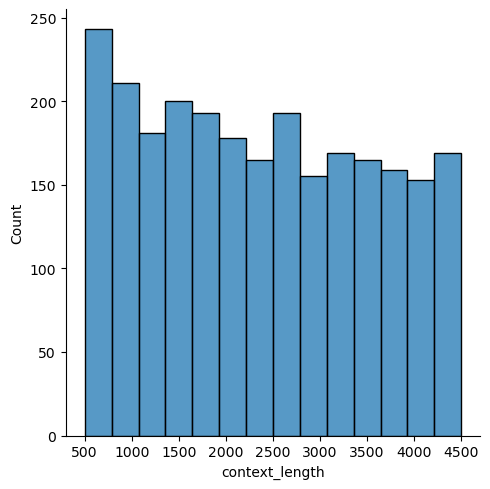

In [9]:
mask = books.record_id.isin(book_ids)
selected_books = books[mask].query("context_length <4500 & context_length > 500")

sns.displot(selected_books, x ='context_length')

In [10]:
SCHEMA = '''{
    "title": "title of the story (string)", 
    "genre": string, 
    "characters": [{"name": string, "description": string. If not available set it to none} (one dict per character)], 
    "author": "the author of the story. If not available, set it to None", 
    "summary": "a brief summary of the story. Do not write more than 50 words"
}
'''

TEMPLATE = '''
You are an assistant designed to provide information in JSON format. 
I will give you a fairy tale, and you need to extract and return specific details from the story. 
Your response should follow exactly this template:

<schema>
{schema}
</schema>

{content}

Do not output anything else than the JSON.
'''

In [25]:
model.base_model.model.layers[0].self_attn.o_proj

Linear4bit(in_features=4096, out_features=4096, bias=False)

In [26]:
generated_text = {}
decoded = None
for i, (idx, row) in enumerate(selected_books.sort_values("context_length", ascending=False).iterrows()):
    text = row['text']

    prompt = TEMPLATE.format(content = text, schema = SCHEMA)
    schema= SCHEMA
    
    message = [{"role": "user", "content": prompt}]
    template = tokenizer.apply_chat_template(message, tokenize=False)

    instruction = "Your response should follow exactly this template:"

    splits = template.split(instruction)
    initial_prompt = splits[0]
    context = splits[1]

    assert (hash(initial_prompt+instruction+context) == hash(template)), "Error in spliting strings. Initial and final string does not match"

    initial_tokens = tokenizer.encode(initial_prompt, return_tensors='pt')
    # open_tag_tokens = tokenizer.encode("<schema>\n", return_tensors='pt')
    # schema_tokens = tokenizer.encode(schema, return_tensors='pt')
    instruction_tokens=  tokenizer.encode(instruction, return_tensors='pt')
    # close_tag_tokens = tokenizer.encode("\n</schema>", return_tensors='pt')
    context_tokens = tokenizer.encode(context, return_tensors='pt')

    start_idx = initial_tokens.size(1)
    end_idx = start_idx + instruction_tokens.size(1) - 1

    model.set_reference_tokens(start_idx, end_idx)
    
    tokens = torch.concat([
        initial_tokens.squeeze(), 
        instruction_tokens.squeeze()[1:],
        # open_tag_tokens.squeeze()[1:],
        # schema_tokens.squeeze()[1:],
        # close_tag_tokens.squeeze()[1:],
        context_tokens.squeeze()[1:]
    ]).unsqueeze(0)

    q = tokenizer.decode(tokens.squeeze()[start_idx: end_idx])

    assert instruction in q, "Error in tokenization. Not giving attention to correct tokens"

    tokens2 = tokenizer(template, return_tensors='pt')

    assert (abs(tokens.shape[1] - tokens2['input_ids'].shape[1]) <=5 ), "Error in tokenization. Tokens do not match"

    clear_output()
    
    if decoded is not None:
        is_json = True    
        json_obj = decoded.split("[/INST]")[1]\
            .replace("\n", '')\
            .replace('</s>', '')\
            .replace('\r', '')\
            .replace('          ', '')\
            .replace("\\", '')
        
        try:
            json_obj   = json.loads(json_obj)

        except:
            is_json = False

        print(
            f'''
            text index = {i},
            context length = {row['context_length']},
            start index = {start_idx}
            end index = {end_idx}
            last generated text = 
{decoded.split('[/INST]')[1]}
            is json = {is_json}    
            delta = {DELTA_ATTENTION}
            keys = {None if not is_json else json_obj.keys()}
            '''
        )

    with torch.no_grad():
        generated_ids = model.generate(
            tokens, 
            max_new_tokens = 1_000, 
            # suppress_tokens = [endline_token, tab_token, double_backspace_token, backspace_token, triple_backspace_token],
            # forced_decoder_ids = [[0, left_brace_token]],
            do_sample = False,
        )

    decoded = (tokenizer.batch_decode(generated_ids)[0])

    generated_text[idx] = {
        "generated_text": decoded,
        "original_text": text,
        "schema" : schema,
        "context_length" : row['context_length'],
        "book_id": row['record_id']
    }


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/users/eleves-a/2022/pedro.silva/Desktop/pay_attention_to_what_matters/.conda/lib/python3.11/site-packages/transformers/generation/utils.py:1792: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


input shape: torch.Size([1, 4607, 4096])
1 4607
Attn output shape before proj torch.Size([1, 4607, 4096])
Attn output shape after proj torch.Size([1, 4607, 4096])
input shape: torch.Size([1, 4607, 4096])
1 4607
Attn output shape before proj torch.Size([1, 4607, 4096])
Attn output shape after proj torch.Size([1, 4607, 4096])
input shape: torch.Size([1, 4607, 4096])
1 4607
Attn output shape before proj torch.Size([1, 4607, 4096])
Attn output shape after proj torch.Size([1, 4607, 4096])
input shape: torch.Size([1, 4607, 4096])
1 4607
Attn output shape before proj torch.Size([1, 4607, 4096])
Attn output shape after proj torch.Size([1, 4607, 4096])
input shape: torch.Size([1, 4607, 4096])
1 4607
Attn output shape before proj torch.Size([1, 4607, 4096])
Attn output shape after proj torch.Size([1, 4607, 4096])
input shape: torch.Size([1, 4607, 4096])
1 4607
Attn output shape before proj torch.Size([1, 4607, 4096])
Attn output shape after proj torch.Size([1, 4607, 4096])
input shape: torch.Siz

KeyboardInterrupt: 

In [12]:
pd.DataFrame(generated_text).T\
    .to_parquet("data/study-04-json/generation1.parquet")

In [14]:
generated_text_df = pd.DataFrame(generated_text).T

generated_text_df['generated_text'] = generated_text_df['generated_text']\
    .apply(lambda x: x.split('[/INST]')[1])

In [34]:
def get_json(x):
    s = x.replace('\n', '')\
        .replace('<schema>', '')\
        .replace('</s>', '')\
        .replace('\_','_')
    
    try:
        return json.loads(s)

    except Exception as e:
        print()
        print(e)
        print(s)

        return np.nan

In [35]:
generated_text_df['json'] = generated_text_df['generated_text']\
    .apply(get_json)


Unterminated string starting at: line 1 column 97 (char 96)
 {"title": "The Elderbush","author": "Hans Christian Andersen","genre": "Fairy Tale","summary": "A young boy is sick and his mother tells him a story about an old man who lives alone and tells fairy tales. The boy listens to the story and falls asleep. When he wakes up, he finds that the old man has disappeared and his mother tells him that the story was just a dream. The boy then falls asleep again and wakes up to find that the old man has returned and is telling him another story. This time, the boy listens intently and remembers the details of the story. The old man then disappears again and the boy wakes up to find that the story was just a dream. The boy then falls asleep again and wakes up to find that the old man has returned and is telling him another story. This time, the boy listens intently and remembers the details of the story. The old man then disappears again and the boy wakes up to find that the story was just

In [39]:
generated_text_df['score'] = 1- generated_text_df['json'].isna()

In [42]:
generated_text_df['context_length_bins'] = pd.cut(
    generated_text_df['context_length'],
    range(0, 5_000, 500)
)

/tmp/ipykernel_953839/441805470.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  generated_text_df.groupby('context_length_bins')\


<Axes: xlabel='context_length_bins'>

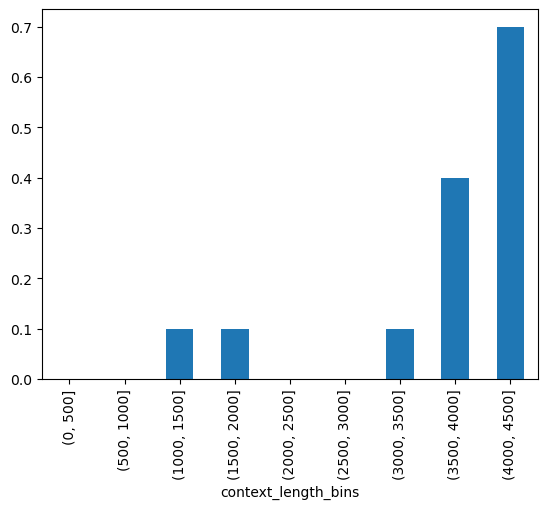

In [47]:
generated_text_df.groupby('context_length_bins')\
    .score\
    .mean()\
    .plot\
    .bar()

In [37]:
print(generated_text_df[generated_text_df['json'].isna()]['generated_text'].iloc[3])

 <schema>
{
"title": "The Haunted House",
"genre": "Horror",
"characters": [
{"name": "Billy", "age": 10},
{"name": "Sam", "age": 9},
{"name": "Jessica", "age": 15},
{"name": "Jasmine", "age": 15},
{"name": "Olu", "age": 17},
{"name": "Joshua", "age": 13},
{"name": "Sadina", "age": 14},
{"name": "Joseph", "age": 6},
{"name": "Dream keepers (Bad ones)", "age": None},
{"name": "Dream keepers (Good ones)", "age": None},
{"name": "Narrator", "age": 13}
],
"prologue": "Hello and welcome to the house of doom. Where all your parents are hung and dead. Where dreams are haunted. Where lives are to be sacrificed to live. Children out of all things must participate or shall see their parent's die by the hands of us dream keepers. We dream keepers are not the nice ones. We haunt people in their dream and leave them crying to sleep. We may act nice but listen to me, Don't trust us .",
"chapter1": "When I was younger I made a promise to a devil. A devil of some sort with devils on his head and had a